In [1]:
from pathlib import Path
import json
import os
import requests
from PIL import Image as PilImage
import io
import numpy as np

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
# change to match
path = Path('/home/msadmin/.fastai/data/ubir-wurrkeng')
masks_path = os.path.join(path, 'masks')
images_path = os.path.join(path, 'images')

### Download Masks and Merge

In [4]:
# log into labelbox and export the labels
# provide latest export file
export_file_path = os.path.join(path, 'export-2019-11-15T04_26_35.478Z.json')

In [5]:
# static mapping of colour to classes
healthy_habitat_colours = {"bare_ground" : [255, 0, 0],
                           "burnt_para_grass" : [255, 165, 0],
                           "dead_para_grass" : [255, 255, 0],
                           "dense_para_grass" : [154, 205, 50],
                           "other_grass" : [0, 128, 128],
                           "lily" : [0,128,0],
                           "para_grass" : [0, 255, 255],
                           "tree" : [173, 216, 230],
                           "water" : [0, 0, 255],
                           "wet_para_grass" : [128, 0, 128],
                           "unlabelled" : [0, 0, 0]}  

def mask_merge(new_img, mask):
    updated_img = np.asarray(new_img.convert('RGB')).copy()
    maskR = updated_img[:, :, 0] > 0
    maskG = updated_img[:, :, 1] > 0
    maskB = updated_img[:, :, 2] > 0
    updated_img[maskR] = healthy_habitat_colours[mask]
    updated_img[maskG] = healthy_habitat_colours[mask]
    updated_img[maskB] = healthy_habitat_colours[mask]
    return updated_img

# download both files and masks
# check for files
with open(export_file_path, 'r') as export_file:
    data = json.load(export_file)
    for row in data:
        if (len(row['Label']['objects']) > 0): # export.json also contains images that haven't been labelled, so just pick out images with labels
            # download source image
            image_url = row['Labeled Data']
            image_name = image_url.split('?')[0].split('-')[-1]
            parts = image_name.split('.')
            image_name = '{0}.{1}'.format(parts[0], 'png')
            image_path = os.path.join(images_path, image_name)
            if not os.path.exists(image_path):
                print('Downloading {0}...'.format(image_path))
                response = requests.get(image_url)
                image = PilImage.open(io.BytesIO(response.content))
                image = image.convert('RGB')
                image.save(image_path)
            else:
                print('{0} exists.'.format(image_path))  
                image = PilImage.open(image_path) # open image just to get size
            #create empty mask to fill with json values
            width, height = image.size
            num_classes = len(healthy_habitat_colours)
            #combined_mask = np.zeros([width,height,num_classes])
            combined_mask = np.zeros([width,height,3], dtype=np.uint8)
            # download masks and combine
            for object in row['Label']['objects']:
                parts = image_name.split('.')
                mask_name = '{0}.{1}'.format(parts[0], 'png')
                mask_path = os.path.join(masks_path, mask_name)         
                mask_class = object['value']
                response = requests.get(object['instanceURI'])
                new_img = PilImage.open(io.BytesIO(response.content))
                mask_img = mask_merge(new_img, mask_class)
                combined_mask = combined_mask + mask_img
            PilImage.fromarray(combined_mask).save(mask_path)  

/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0474.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0118.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0150.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0182.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0214.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0280.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0312.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0377.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0410.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0442.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0477.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0574.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0025.png exists.
/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0153.png exists.
/home/msadmin/.fastai/data/ubir-wu

In [6]:
# Change RGB to greyscale for Camvid style processing

In [7]:
def get_class_values(label_names):
    values = set([])
    for i in range(len(label_names)):
        tmp = open_mask(label_names[i])
        tmp = tmp.data.numpy().flatten()
        tmp = set(tmp)
        values = values.union(tmp)   
    return list(values)

def replace_mask(mask, values):
    num_class = len(values)
    new_mask = np.zeros(mask.shape)
    for i in range(num_class):
        new_mask[mask == values[i]] = i   
    return new_mask

def convert_mask_to_image(mask, save_path):
    image_size = mask.squeeze().shape
    image = PilImage.new('L',(image_size[1],image_size[0]))
    image.putdata(mask.astype('uint8').ravel())
    image.save(save_path)

def convert_mask_greyscale(masks_path, save_path):
    label_names = get_image_files(masks_path)
    values = get_class_values(label_names)
    for file in label_names:
        current_mask = open_mask(file).data.numpy()
        converted_mask = replace_mask(current_mask, values)
        convert_mask_to_image(converted_mask, os.path.join(save_path, file.name)) 
    print('Masks converted to classes!')

In [8]:
class_path = '/home/msadmin/.fastai/data/ubir-wurrkeng/classes/'

In [9]:
convert_mask_greyscale(masks_path, class_path)

Masks converted to classes!


In [10]:
masks_path = os.path.join(path, 'classes')

## Image segmentation with UNet/HealthyHabitat

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Data

In [13]:
fnames = get_image_files(images_path)
fnames[:3]

[PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0442.png'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0445.png'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/DJI_0428.png')]

In [14]:
lbl_names = get_image_files(masks_path)
lbl_names[:3]

[PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/classes/DJI_0442.png'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/classes/DJI_0445.png'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/classes/DJI_0428.png')]

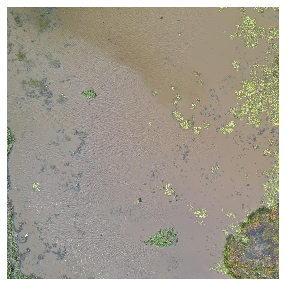

In [15]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [16]:
# function to replace original image file name with mask name in different folder
get_y_fn = lambda x: os.path.join(masks_path, '{0}'.format(x.name))

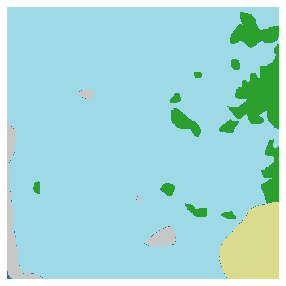

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

## Datasets

In [18]:
# load classes either from text file or directly as np array
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['bare_ground', 'burnt_para_grass', 'dead_para_grass', 'dense_para_grass', 'other_grass', 'lily', 'para_grass',
       'tree', 'water', 'wet_para_grass', 'unlabelled'], dtype='<U16')

In [19]:
src_size = np.array(mask.shape[1:])

In [20]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 11140MB of GPU RAM free


In [21]:
#src.datasets(SegmentationDataset, classes=codes, div=True)

In [22]:
### Customer label due to labelbox using 0,255 Mask instead of 0,1,2,3
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

#codes = ['0','1','2','3','4','5','6','7','8','9','10','11']
codes = ['bare_ground','burnt_para_grass','dead_para_grass','dense_para_grass','other_grass','lily',
         'para_grass','tree','water','wet_para_grass','unlabelled']
src = (SegItemListCustom.from_folder(images_path)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

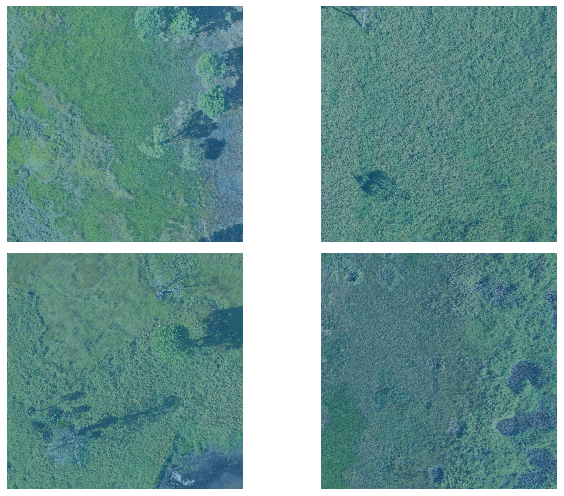

In [23]:
data.show_batch(2, figsize=(10,7))

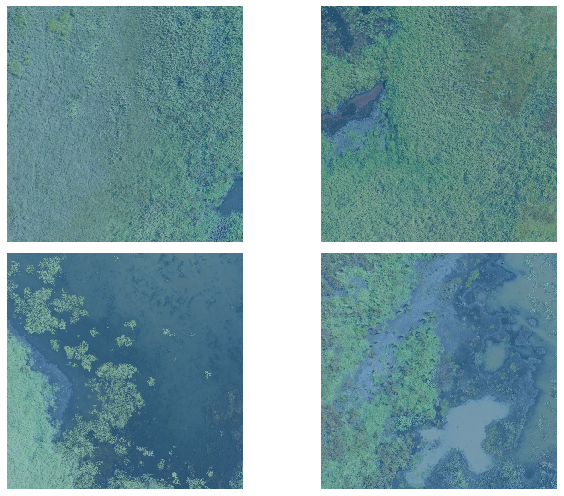

In [24]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [25]:
## Custom loss
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [26]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."

    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [27]:
metrics = [dice_loss, accuracy_thresh, dice]
#metrics=accuracy

In [28]:
wd=1e-2

In [29]:
#learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn = unet_learner(data, models.resnet34, wd=wd, metrics=metrics)

In [30]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


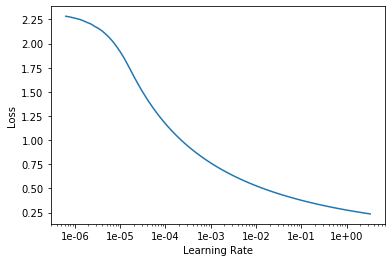

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=1e-3

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
#learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.000000,0.000000,0.999721,0.816962,1.000000,00:16
1,0.000000,0.000000,0.999721,0.816984,1.000000,00:16
2,0.000000,0.000000,0.999721,0.817019,1.000000,00:16
3,0.000000,0.000000,0.999721,0.817056,1.000000,00:16
4,0.000000,0.000000,0.999721,0.817088,1.000000,00:16
5,0.000000,0.000000,0.999721,0.817098,1.000000,00:16
6,0.000000,0.000000,0.999721,0.817105,1.000000,00:16
7,0.000000,0.000000,0.999721,0.817106,1.000000,00:16
8,0.000000,0.000000,0.999721,0.817105,1.000000,00:16
9,0.000000,0.000000,0.999721,0.817106,1.000000,00:16


In [35]:
learn.save('stage-1')

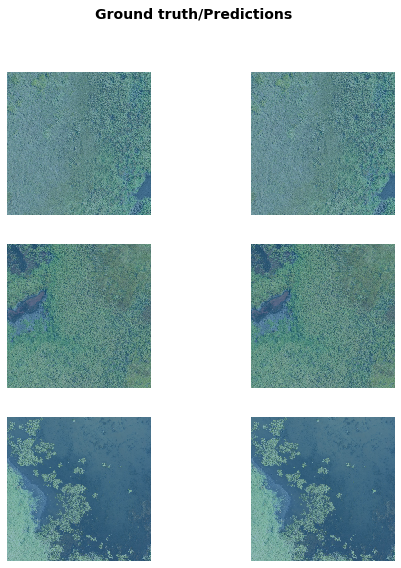

In [36]:
learn.show_results(rows=3, figsize=(8,9))

In [37]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [38]:
outputs.shape

torch.Size([4, 11, 512, 512])

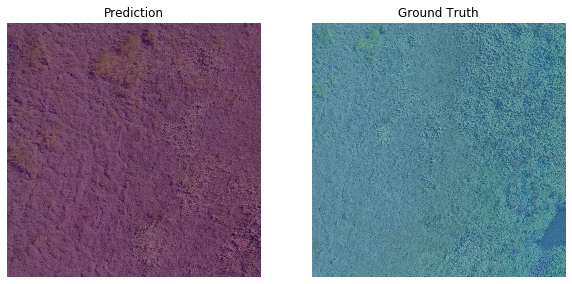

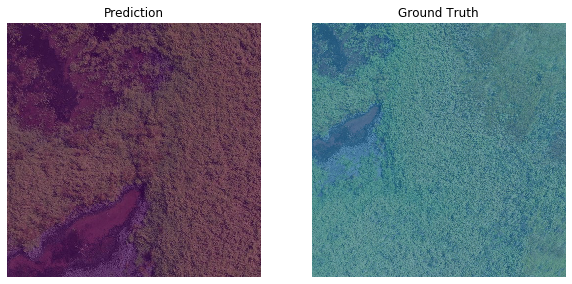

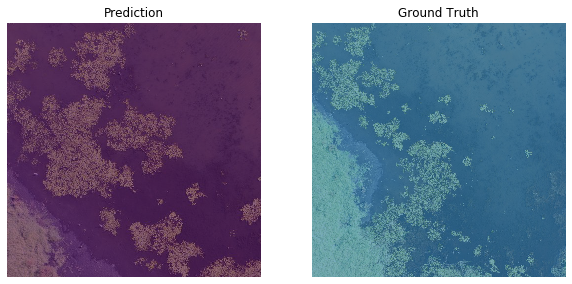

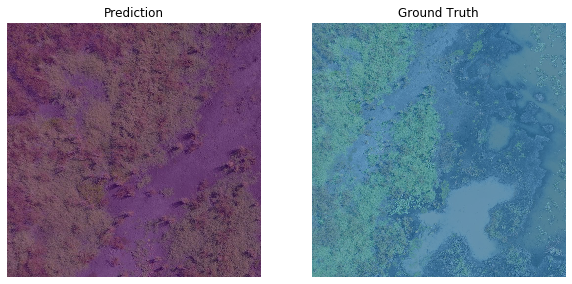

In [39]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.95)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

### Interpretation

In [40]:
from fastai.vision.interpret import SegmentationInterpretation
interp = SegmentationInterpretation.from_learner(learn)

In [41]:
# Since FlattenedLoss of CrossEntropyLoss() is used we reshape and then take the mean of pixel losses per image. 
# In order to do so we need to pass sizes:tuple to top_losses()
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

(array([  0.,   0.,   0.,   0.,   0., 112.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5], dtype=float32),
 <a list of 10 Patch objects>)

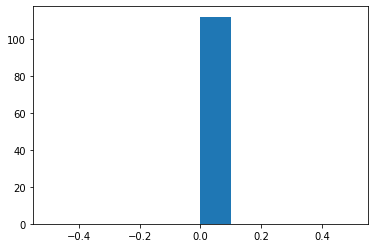

In [42]:
import matplotlib.pyplot as plt 
plt.hist(top_losses)

In [43]:
# Next, we can generate a confusion matrix similar to what we usually have for classification. 
# Two confusion matrices are generated: mean_cm which represents the global label performance 
#  and single_img_cm which represents the same thing but for each individual image in datase
learn.data.classes

['bare_ground',
 'burnt_para_grass',
 'dead_para_grass',
 'dense_para_grass',
 'other_grass',
 'lily',
 'para_grass',
 'tree',
 'water',
 'wet_para_grass',
 'unlabelled']

In [44]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
bare_ground,1
burnt_para_grass,NaN
dead_para_grass,NaN
dense_para_grass,NaN
other_grass,NaN
lily,NaN
para_grass,NaN
tree,NaN
water,NaN
wet_para_grass,NaN


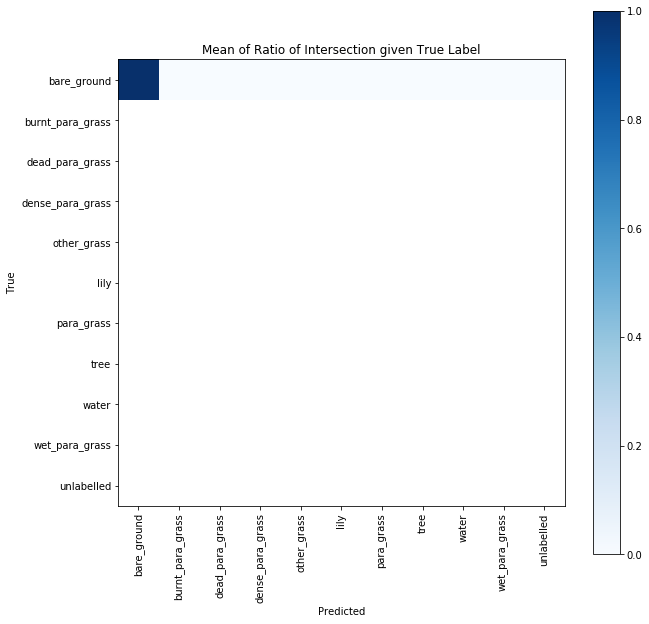

In [45]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [46]:
# look at the single worst prediction in our dataset
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

IndexError: index 77 is out of bounds for axis 0 with size 7

In [ ]:
interp.show_xyz(i, sz=15)

### Continue training

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))